In [24]:
from google.colab import drive
drive.mount('./montura')
!sudo ls /content/montura/MyDrive/TFG/tagger/

Drive already mounted at ./montura; to attempt to forcibly remount, call drive.mount("./montura", force_remount=True).
 experimentos.gdoc		      tagger_en.ipynb
 experiments.gdoc		      tagger_es.ipynb
'Hoja de cálculo sin título.gsheet'   universal_tagset-ES.map


In [25]:
import nltk
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

import nltk
nltk.download('universal_tagset')
nltk.download('cess_esp')
!cp /content/montura/MyDrive/TFG/tagger/universal_tagset-ES.map ~/nltk_data/taggers/universal_tagset/es-ancora.map
from nltk.corpus import cess_esp

sentences = cess_esp.tagged_sents()

print(sentences[0])

print("Number of Tagged Sentences ",len(sentences))
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')]
Number of Tagged Sentences  6030


In [26]:
cess_esp._tagset = 'es-ancora'
sentences = cess_esp.tagged_sents(tagset='universal')
print(sentences[0])

[('El', 'DET'), ('grupo', 'NOUN'), ('estatal', 'ADJ'), ('Electricité_de_France', 'NOUN'), ('-Fpa-', '.'), ('EDF', 'NOUN'), ('-Fpt-', '.'), ('anunció', 'VERB'), ('hoy', 'ADV'), (',', '.'), ('jueves', 'X'), (',', '.'), ('la', 'DET'), ('compra', 'NOUN'), ('del', 'ADP'), ('51_por_ciento', 'NUM'), ('de', 'ADP'), ('la', 'DET'), ('empresa', 'NOUN'), ('mexicana', 'ADJ'), ('Electricidad_Águila_de_Altamira', 'NOUN'), ('-Fpa-', '.'), ('EAA', 'NOUN'), ('-Fpt-', '.'), (',', '.'), ('creada', 'ADJ'), ('por', 'ADP'), ('el', 'DET'), ('japonés', 'ADJ'), ('Mitsubishi_Corporation', 'NOUN'), ('para', 'ADP'), ('poner_en_marcha', 'VERB'), ('una', 'DET'), ('central', 'NOUN'), ('de', 'ADP'), ('gas', 'NOUN'), ('de', 'ADP'), ('495', 'X'), ('megavatios', 'NOUN'), ('.', '.')]


In [27]:


word_to_idx = {'UNK':0}
tag_to_idx = {}
char_to_idx = {'UNK':0}


def prepare_words(seq,to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix.keys():
            idxs.append(to_ix['UNK'])
        else:
            idxs.append(to_ix[w])
    return torch.tensor(idxs, dtype=torch.long,device=device)

        

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long,device=device)
def prepare_chars(sentence, to_ix):
    indexes = []
    for word in sentence:
        idxs = []
        for char in word:
            if char not in to_ix.keys():
                idxs.append(to_ix['UNK'])
            else:
                idxs.append(to_ix[char])
        indexes.append(idxs)
    max_length = max(len(row) for row in indexes)
    padded =   [row + [0] * (max_length - len(row))  for row in indexes]
    return torch.tensor(padded, dtype=torch.long,device=device)


for sentence in sentences:
    for word, tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if tag not in tag_to_idx.keys():
            tag_to_idx[tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

print(len(word_to_idx),len(tag_to_idx),len(char_to_idx))

25465 11 96


In [28]:
print(tag_to_idx)
idx_to_tag = {}
confusion_matrix_labels = []
for key, index in tag_to_idx.items():
    idx_to_tag[index] = key
    confusion_matrix_labels.append(key)
print(idx_to_tag)


{'DET': 0, 'NOUN': 1, 'ADJ': 2, '.': 3, 'VERB': 4, 'ADV': 5, 'X': 6, 'ADP': 7, 'NUM': 8, 'CONJ': 9, 'PRON': 10}
{0: 'DET', 1: 'NOUN', 2: 'ADJ', 3: '.', 4: 'VERB', 5: 'ADV', 6: 'X', 7: 'ADP', 8: 'NUM', 9: 'CONJ', 10: 'PRON'}


In [29]:
class Features():
    def fill(self, word_to_idx, tag_to_idx, char_to_idx):
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        self.char_to_idx = char_to_idx
        
        self.idx_to_tag = {}
        for key,index in self.tag_to_idx.items():
            self.idx_to_tag[index] = key
        
    def save(self):
        """save class as self.name.txt"""
        file = open('features_es.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('features_es.txt','rb')
        dataPickle = file.read()
        file.close()

features = Features()
features.fill(word_to_idx, tag_to_idx, char_to_idx)
features.save()

print(features)


In [30]:
data = []
for sentence in sentences:
    words = []
    tags = []
    for word, tag in sentence:
        words.append(word) 
        tags.append(tag)
    data.append((words,tags))

train_len = math.floor(len(data)*0.8)
val_len = math.floor(len(data)*0.1)
test_len = math.floor(len(data)*0.1)

train = data[:train_len]
validation = data[train_len:train_len+val_len]
test = data[train_len+val_len:]
print(len(train),len(validation),len(test))

4824 603 603


In [31]:
# class LSTMTagger(nn.Module):

#     def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_vocab_size, tagset_size):
#         super(LSTMTagger, self).__init__()
#         self.hidden_dim = hidden_dim

#         self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

#         # The LSTM takes word embeddings as inputs, and outputs hidden states
#         # with dimensionality hidden_dim.
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

#         self.lstm_output_dropout = torch.nn.Dropout(1 - KEEP_DROPOUT)

#         # The linear layer that maps from hidden state space to tag space
#         self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        

#     def forward(self, sentence):
#         embeds = self.word_embeddings(sentence)
#         lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
#         lstm_out_dropped = self.lstm_output_dropout(lstm_out)
#         tag_space = self.hidden2tag(lstm_out_dropped.view(len(sentence), -1))
#         tag_scores = F.log_softmax(tag_space, dim=1)
#         return tag_scores


In [32]:
class char_LSTM(nn.Module):
    '''El Chapo'''
    def __init__(self, char_embedding_dim, char_hidden_dim, charset_size):
        super(char_LSTM, self).__init__()
        
        self.char_hidden_dim = char_hidden_dim
        self.char_embedding = nn.Embedding(charset_size, char_embedding_dim)
        self.lstm = nn.LSTM(char_embedding_dim, char_hidden_dim)
        self.char_hidden = self.init_hidden()
        
    def init_hidden(self):
        ''' Intialize the hidden state'''
        return (torch.rand(1,1,self.char_hidden_dim,device=device),
               torch.rand(1,1,self.char_hidden_dim,device=device))
    
    def forward(self,single_word):
        ''' Return the final hidden state a.k.a char embedding(This encodes dense character features )'''
        char_embeds = self.char_embedding(single_word)
        self.char_hidden = self.init_hidden()
        _, self.char_hidden = self.lstm(char_embeds.view(len(single_word),1,-1),self.char_hidden)
        return self.char_hidden[0]

class LSTMTagger(nn.Module):
    '''GodFather'''
    def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.char_LSTM_embedding = char_LSTM(char_embedding_dim, char_hidden_dim, char_size)
        # note : LSTM input size is embedding_dim+char_hidden_dim to play nicely with concatenation
        self.lstm = nn.LSTM(embedding_dim+char_hidden_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()
        
    def init_hidden(self):
        ''' Intialize the hidden state'''
        return (torch.rand(1,1,self.hidden_dim,device=device),
               torch.randn(1,1,self.hidden_dim,device=device))
    
    def concat_embeddings(self,some_word_embedding_tensor, some_character_embedding_tensor):
        ''' Concatenate the word embedding and character embedding into a single tensor. Do this for all words'''
        combo = []
        for w,c in zip(some_word_embedding_tensor,some_character_embedding_tensor):
            combo.append(torch.cat((w,c)))
        return torch.stack(combo)
    
    def forward(self, sentence, sentence_chars):
        word_embeds = self.word_embeddings(sentence)
        char_embeds = []
        for single_word_char in sentence_chars:
            # iterate through each word and append the character embedding to char_embeds
            char_embeds.append(torch.squeeze(self.char_LSTM_embedding(single_word_char)))
        # Concatenate the word embedding with the char embedding( i.e the hidden state from the char_LSTM for each word)
        word_char_embeds = self.concat_embeddings(word_embeds, char_embeds)
        lstm_out, self.hidden = self.lstm(word_char_embeds.view(len(sentence), 1, -1), (self.hidden[0].detach(), self.hidden[1].detach()))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence),-1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [33]:
WORD_EMBEDDING_DIM = 300
CHAR_EMBEDDING_DIM = 100
WORD_HIDDEN_DIM = 1024
CHAR_HIDDEN_DIM = 256
KEEP_DROPOUT = 0.8


In [34]:
model = LSTMTagger(WORD_EMBEDDING_DIM, CHAR_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_HIDDEN_DIM,
                   len(word_to_idx), len(char_to_idx), len(tag_to_idx))

model.to(device)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

import tqdm
def trainer(model, loss_function, optimizer, train):
    total_loss = 0
    predictions = []
    trues = []

    for sentence, tags in tqdm.tqdm(train):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_words(sentence, word_to_idx)
        char_sequence = prepare_chars(sentence, char_to_idx)
        
        targets = prepare_sequence(tags, tag_to_idx)
        sentence_in.to(device)
        char_sequence.to(device)
        targets.to(device)

        # Step 3. Run our forward pass.
        # tag_scores = model(sentence_in)
        tag_scores = model(sentence_in, char_sequence)
        # print(tag_scores.size())
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        # tag_scores = torch.squeeze(tag_scores,0)
        # print(tag_scores.size())

        loss = loss_function(tag_scores, targets)
        total_loss += loss.item()

        _, indices = torch.max(tag_scores, 1)

        predictions = predictions + indices.tolist()
        trues = trues + targets.tolist()

        loss.backward()
        optimizer.step()
    return total_loss, predictions, trues
    

def tester(model, loss_function, test):
    total_loss = 0
    predictions = []
    trues = []

    for sentence, tags in tqdm.tqdm(test):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_words(sentence, word_to_idx)
        char_sequence = prepare_chars(sentence, char_to_idx)
        targets = prepare_sequence(tags, tag_to_idx)
        sentence_in.to(device)
        char_sequence.to(device)
        targets.to(device)

        # Step 3. Run our forward pass.
        # tag_scores = model(sentence_in)
        tag_scores = model(sentence_in,char_sequence)

        # tag_scores = torch.squeeze(tag_scores,0)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        
        loss = loss_function(tag_scores, targets)
        total_loss += loss.item()

        
        

        # Caluclating the accuracy of tags
        _, indices = torch.max(tag_scores, 1)

        predictions = predictions + indices.tolist()
        trues = trues + targets.tolist()
    
    return total_loss, predictions, trues
    
    


In [35]:
from sklearn.metrics import f1_score, accuracy_score
import tqdm
TOTAL_EPOCHS = 17
train_losses = []
validation_losses = []
accuracies_t = []
accuracies_v = []
f1s_t = []
f1s_v = []
for epoch in range(TOTAL_EPOCHS):
    train_loss, pred_t, true_t = trainer(model, loss_function, optimizer,train)
    val_loss, pred_v, true_v = tester(model, loss_function, validation)
    print(f"EPOCH: {epoch}")
    print(f"TRAIN LOSS: {train_loss}")
    print(f"VALIDATION LOSS: {val_loss}")
    accuracy_v = accuracy_score(true_v, pred_v)
    accuracy_t = accuracy_score(true_t, pred_t)
    f1_v = f1_score(true_v, pred_v, average='weighted')
    f1_t = f1_score(true_t, pred_t, average='weighted')
    
    print(f"TRAIN ACC: {accuracy_t}")
    print(f"VAL ACC: {accuracy_v}")

    print(f"TRAIN F-1: {f1_t}")
    print(f"VAL F-1: {f1_v}")

    f1s_t.append(f1_t)
    f1s_v.append(f1_v)
    accuracies_t.append(accuracy_t)
    accuracies_v.append(accuracy_v)
    train_losses.append(train_loss)
    validation_losses.append(val_loss)

100%|██████████| 603/603 [00:07<00:00, 84.70it/s]


EPOCH: 0
TRAIN LOSS: 5189.276324915234
VALIDATION LOSS: 452.69461722671986
TRAIN ACC: 0.6684858861123301
VAL ACC: 0.7617471481766062
TRAIN F-1: 0.6374922670626549
VAL F-1: 0.7432833451101581


100%|██████████| 603/603 [00:07<00:00, 84.63it/s]


EPOCH: 1
TRAIN LOSS: 2973.7968919316772
VALIDATION LOSS: 350.3860444650054
TRAIN ACC: 0.7997972693165875
VAL ACC: 0.814114309356345
TRAIN F-1: 0.7829585978377457
VAL F-1: 0.8067492528098947


100%|██████████| 603/603 [00:07<00:00, 84.39it/s]


EPOCH: 2
TRAIN LOSS: 2457.5993920248
VALIDATION LOSS: 313.49342173710465
TRAIN ACC: 0.8364680359228882
VAL ACC: 0.8348602163248419
TRAIN F-1: 0.8265821313984724
VAL F-1: 0.8284500224126193


100%|██████████| 603/603 [00:07<00:00, 84.99it/s]


EPOCH: 3
TRAIN LOSS: 2093.8412272012793
VALIDATION LOSS: 277.65856786444783
TRAIN ACC: 0.8597078947531074
VAL ACC: 0.8514687629292511
TRAIN F-1: 0.8538183644582591
VAL F-1: 0.8444792987781535


100%|██████████| 603/603 [00:07<00:00, 84.34it/s]


EPOCH: 4
TRAIN LOSS: 1714.3722319160588
VALIDATION LOSS: 244.05311092361808
TRAIN ACC: 0.8852964627204233
VAL ACC: 0.8704415154559962
TRAIN F-1: 0.8826317678723795
VAL F-1: 0.8657633945748902


100%|██████████| 603/603 [00:07<00:00, 84.81it/s]


EPOCH: 5
TRAIN LOSS: 1437.3097264319658
VALIDATION LOSS: 218.443439360708
TRAIN ACC: 0.903387703889586
VAL ACC: 0.8870500620604055
TRAIN F-1: 0.9016749777818645
VAL F-1: 0.8840253161702794


100%|██████████| 603/603 [00:07<00:00, 79.02it/s]


EPOCH: 6
TRAIN LOSS: 1217.6987909665331
VALIDATION LOSS: 201.12691061012447
TRAIN ACC: 0.9178817115908796
VAL ACC: 0.896684201193924
TRAIN F-1: 0.9166495115051608
VAL F-1: 0.8944215952129752


100%|██████████| 603/603 [00:07<00:00, 84.96it/s]


EPOCH: 7
TRAIN LOSS: 1045.723326108884
VALIDATION LOSS: 185.5651261024177
TRAIN ACC: 0.9297859584278483
VAL ACC: 0.905195342514333
TRAIN F-1: 0.9288632203971569
VAL F-1: 0.9037443959268476


100%|██████████| 603/603 [00:07<00:00, 84.81it/s]


EPOCH: 8
TRAIN LOSS: 911.7935146898963
VALIDATION LOSS: 171.95448685158044
TRAIN ACC: 0.9385318095567738
VAL ACC: 0.9125834860216325
TRAIN F-1: 0.937851745288554
VAL F-1: 0.9115635837411326


100%|██████████| 603/603 [00:08<00:00, 75.02it/s]


EPOCH: 9
TRAIN LOSS: 789.3901968958089
VALIDATION LOSS: 163.75638231262565
TRAIN ACC: 0.9462145607604873
VAL ACC: 0.9167208463857202
TRAIN F-1: 0.945719215131968
VAL F-1: 0.9157874406591731


100%|██████████| 603/603 [00:07<00:00, 85.28it/s]


EPOCH: 10
TRAIN LOSS: 681.5118151395
VALIDATION LOSS: 155.90590433916077
TRAIN ACC: 0.9536562602369724
VAL ACC: 0.9224540457473845
TRAIN F-1: 0.9532784023939463
VAL F-1: 0.9217872455024408


100%|██████████| 603/603 [00:07<00:00, 85.02it/s]


EPOCH: 11
TRAIN LOSS: 590.2858651485876
VALIDATION LOSS: 152.25939022004604
TRAIN ACC: 0.9599236051449092
VAL ACC: 0.9246409362255452
TRAIN F-1: 0.9596432284747076
VAL F-1: 0.9241436022971459


100%|██████████| 603/603 [00:07<00:00, 85.01it/s]


EPOCH: 12
TRAIN LOSS: 516.3603600160568
VALIDATION LOSS: 147.3140218204353
TRAIN ACC: 0.9652514663980073
VAL ACC: 0.9273597730362314
TRAIN F-1: 0.9650307539650282
VAL F-1: 0.9267657174955732


100%|██████████| 603/603 [00:07<00:00, 84.77it/s]


EPOCH: 13
TRAIN LOSS: 450.97670934867347
VALIDATION LOSS: 141.92236194736324
TRAIN ACC: 0.9699859695533126
VAL ACC: 0.9295466635143921
TRAIN F-1: 0.9698119778196385
VAL F-1: 0.9289415342079134


100%|██████████| 603/603 [00:07<00:00, 83.81it/s]


EPOCH: 14
TRAIN LOSS: 394.1987071654876
VALIDATION LOSS: 139.6510044299066
TRAIN ACC: 0.9735893838347003
VAL ACC: 0.9313789231042023
TRAIN F-1: 0.9734507541129319
VAL F-1: 0.9306729100232224


100%|██████████| 603/603 [00:07<00:00, 79.63it/s]


EPOCH: 15
TRAIN LOSS: 346.95194556572824
VALIDATION LOSS: 134.91262007097248
TRAIN ACC: 0.9770939050997892
VAL ACC: 0.9345706010993557
TRAIN F-1: 0.9769830229317206
VAL F-1: 0.9340658127338078


100%|██████████| 603/603 [00:07<00:00, 82.50it/s]


EPOCH: 16
TRAIN LOSS: 306.19291164993774
VALIDATION LOSS: 134.5745966794202
TRAIN ACC: 0.9797454740993009
VAL ACC: 0.9368165967255748
TRAIN F-1: 0.9796574328889425
VAL F-1: 0.9363326445966029


In [36]:
test_loss, pred, true = tester(model, loss_function, test)
print(f"VALIDATION LOSS: {test_loss}")
print(f"VAL F-1: {f1_score(true, pred, average='weighted')}")
print(f"VAL ACC: {accuracy_score(true, pred)}")

100%|██████████| 603/603 [00:05<00:00, 104.83it/s]

VALIDATION LOSS: 158.6155585643428
VAL F-1: 0.9244401522343998
VAL ACC: 0.9257298225529479


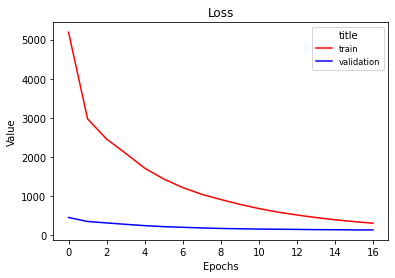

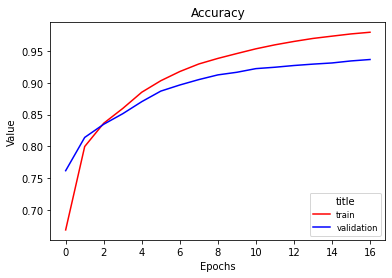

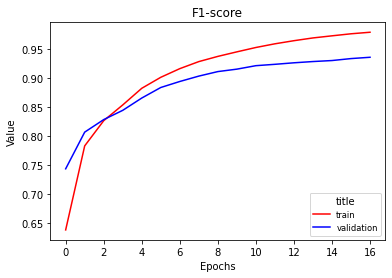

In [37]:
import matplotlib.pyplot as plt
plt.title('Loss')
t, = plt.plot(train_losses, c="red", label ="train")
v, = plt.plot(validation_losses, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v], title="title",loc=1, fontsize='small', fancybox=True)
plt.show()


plt.title('Accuracy')
t, = plt.plot(accuracies_t, c="red", label ="train")
v, = plt.plot(accuracies_v, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v], title="title",loc=4, fontsize='small', fancybox=True)

plt.show()

plt.title('F1-score')
t, = plt.plot(f1s_t, c="red", label ="train")
v, = plt.plot(f1s_v, c="blue", label ="validation")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend(handles=[t,v], title="title",loc=4, fontsize='small', fancybox=True)


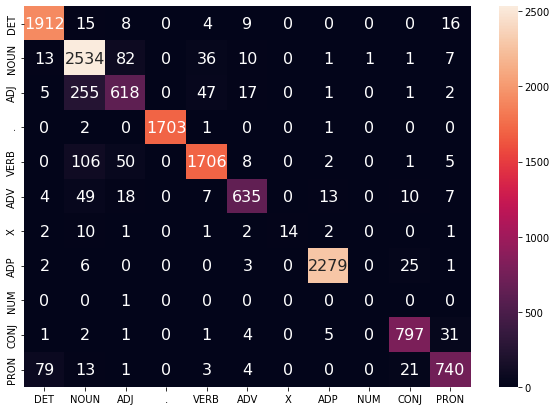

In [38]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


df_cm = pd.DataFrame(confusion_matrix(true, pred), index=confusion_matrix_labels, columns= confusion_matrix_labels)
plt.figure(figsize=(10,7))
# sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='g', annot_kws={"size": 16}) # font size

plt.show()

In [39]:
torch.save(model.state_dict(), './model_file_es')

In [40]:
import pickle
def prepare_words(seq,to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix.keys():
            idxs.append(to_ix['UNK'])
        else:
            idxs.append(to_ix[w])
    return torch.tensor(idxs, dtype=torch.long,device=device)


class Features():
    def fill(self, word_to_idx, tag_to_idx, char_to_idx):
        self.word_to_idx = word_to_idx
        self.tag_to_idx = tag_to_idx
        self.char_to_idx = char_to_idx
        
        self.idx_to_tag = {}
        for key,index in self.tag_to_idx.items():
            self.idx_to_tag[index] = key
        
    def save(self):
        """save class as self.name.txt"""
        file = open('features_es.txt','wb')
        file.write(pickle.dumps(self.__dict__))
        file.close()

    def load(self):
        """try load self.name.txt"""
        file = open('features_es.txt','rb')
        dataPickle = file.read()
        file.close()
        self.__dict__ = pickle.loads(dataPickle)
features = Features()
features.load()


In [41]:
import nltk
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
device = 'cpu'

WORD_EMBEDDING_DIM = 128
CHAR_EMBEDDING_DIM = 32
WORD_HIDDEN_DIM = 128
CHAR_HIDDEN_DIM = 32
KEEP_DROPOUT = 0.8


class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, char_embedding_dim, hidden_dim, char_hidden_dim, vocab_size, char_vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)

        self.lstm_output_dropout = torch.nn.Dropout(1 - KEEP_DROPOUT)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        lstm_out_dropped = self.lstm_output_dropout(lstm_out)
        tag_space = self.hidden2tag(lstm_out_dropped.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores



In [42]:
print(len(features.word_to_idx), len(features.char_to_idx), len(features.tag_to_idx))


model = LSTMTagger(WORD_EMBEDDING_DIM, CHAR_EMBEDDING_DIM, WORD_HIDDEN_DIM, CHAR_HIDDEN_DIM,
                   len(features.word_to_idx), len(features.char_to_idx), len(features.tag_to_idx))
model.load_state_dict(torch.load('./model_file_es'))
model.to(device)


25465 96 11


RuntimeError: ignored

In [ ]:
def predict(model, query):
    query = nltk.word_tokenize(query)
    model.zero_grad()

    sentence_in = prepare_words(query, features.word_to_idx)
    
    tag_scores = model(sentence_in)

    _, indices = torch.max(tag_scores, 1)

    indices = indices.tolist()

    preds = [features.idx_to_tag[x] for x in indices]
    print(preds)
    print(query)
    
predict(model,'Cuándo se ganó el mundial en España?')